# Hematopoiesis

Hematopoiesis dataset from *Weinreb, C., Rodriguez-Fraticelli, A., Camargo, F. D. & Klein, A. M. Science 367, (2020)*. 

This dataset has 3 time points for both the clonal and state measurements. It has ~50000 clonally-labeled cells. Running the whole pipeline for the first time could take 5.2 hours in a standard personal computer.
Most of the time (3.3 h) is used for generating the similarity matrix, which are saved for later usage. 

**Key components:**
    
* Part I: Infer transition map from all clonal data
    
* Part II: Infer transition using end-point clones
    
* Part III: Infer transition map from state information alone
    
* Part IV: Predict fate bias for Gata1+ states

In [1]:
import cospar as cs
import numpy as np

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2
cs.settings.data_path='LARRY_data' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='LARRY_figure' # A relative path to save figures. If not existed before, create a new one.
cs.settings.set_figure_params(format='png',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=2) 

Running cospar 0.1.4 (python 3.6.12) on 2021-04-21 22:25.


In [3]:
# # This is for testing this notebook
# cs.settings.data_path='data_cospar' 
# cs.settings.figure_path='fig_cospar' 
# adata_orig=cs.datasets.hematopoiesis_subsampled()
# adata_orig.uns['data_des']=['blood']

## Loading data

In [4]:
adata_orig=cs.datasets.hematopoiesis()

creating directory LARRY_data/ for saving data
creating directory LARRY_figure/ for saving figures
try downloading from url
https://kleintools.hms.harvard.edu/tools/downloads/cospar/LARRY_adata_preprocessed.h5ad
... this may take a while but only happens once


In [5]:
adata_orig

AnnData object with n_obs × n_vars = 49116 × 25289
    obs: 'time_info', 'state_info'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca'

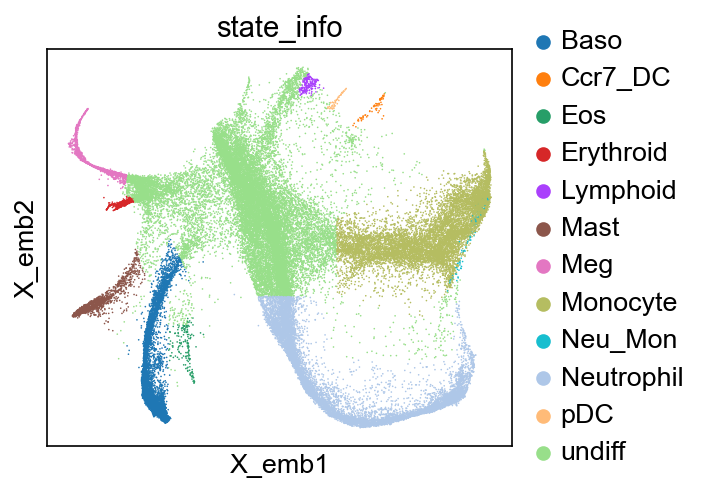

<Figure size 300x262.5 with 0 Axes>

In [6]:
cs.pl.embedding(adata_orig,color='state_info')

In [7]:
cs.hf.check_available_choices(adata_orig)

Current time ordering from simple sorting: ['2' '4' '6']
Available transition maps: []
Available clusters: ['undiff', 'Meg', 'Neu_Mon', 'Monocyte', 'pDC', 'Neutrophil', 'Mast', 'Lymphoid', 'Baso', 'Erythroid', 'Eos', 'Ccr7_DC']
Available time points: ['2' '4' '6']
Clonal time points: ['2' '4' '6']


## Basic clonal analysis

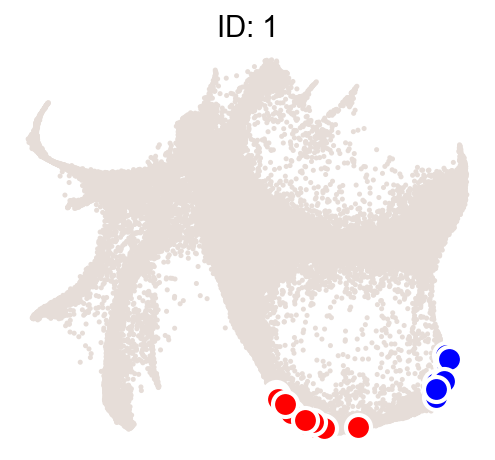

In [8]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1],color_list=['black','red','blue'])

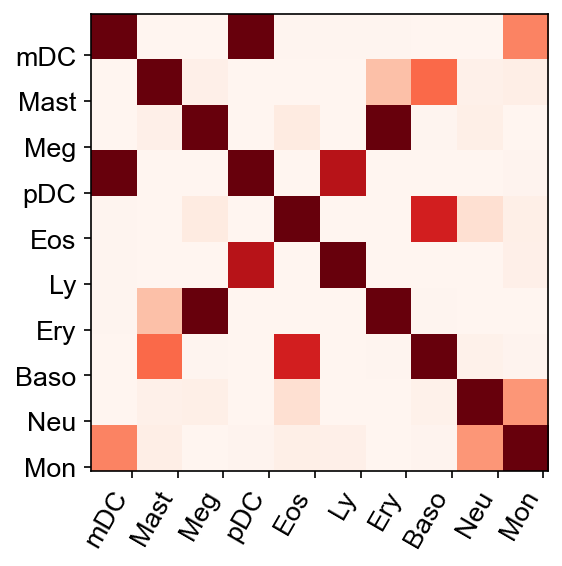

In [9]:
selected_times='4'
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
coupling=cs.pl.fate_coupling_from_clones(adata_orig,selected_times, selected_fates=selected_fates, 
                color_bar=False,rename_fates=celltype_names)

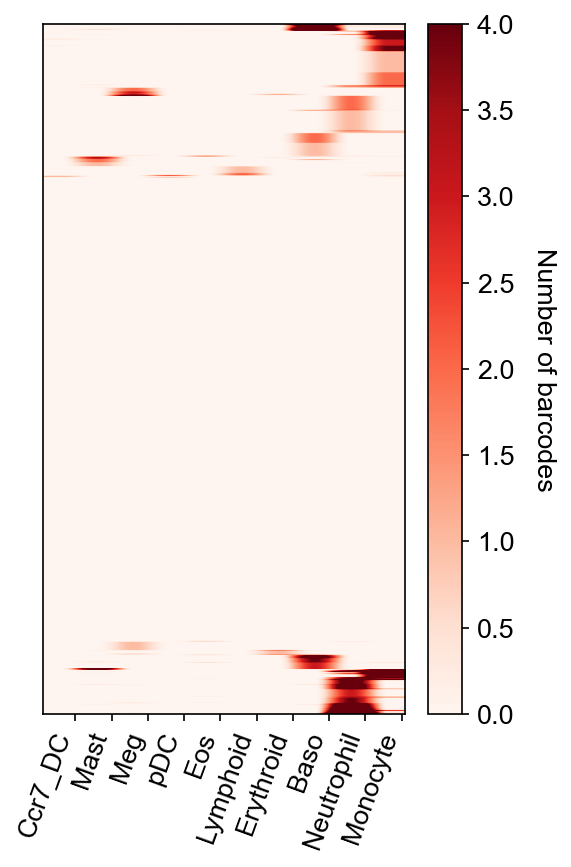

In [10]:
selected_times='4'
cs.pl.barcode_heatmap(adata_orig,selected_times, selected_fates=selected_fates, color_bar=True)

## Part I: Infer transition map from all clonal data

### Map inference

When first run, it takes around 3 h 37 mins, in which 3 h 20 mins are used for computing the similarity matrices and saving these data. It takes only 20 mins for later runs.

In [11]:
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['2','4','6'],later_time_point='6',
        smooth_array=[20,15,10],sparsity_threshold=0.2,max_iter_N=3)

Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 1216
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.903
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 3047
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.97
-----------Total used time: 1270.1618161201477 s ------------


### Save pre-computed data (optional)

In [12]:
save_data=False
if save_data:
    cs.hf.save_map(adata)

### Plotting


#### Transition profiles for single cells

Forward transitions with `map_backward=False`.

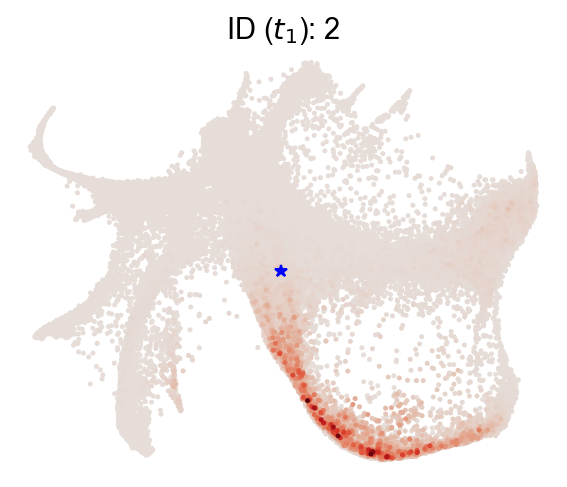

In [13]:
selected_state_id_list=[2]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list, color_bar=False,
                                    used_Tmap='transition_map',map_backward=False)

Backward transitions with `map_backward=True`.

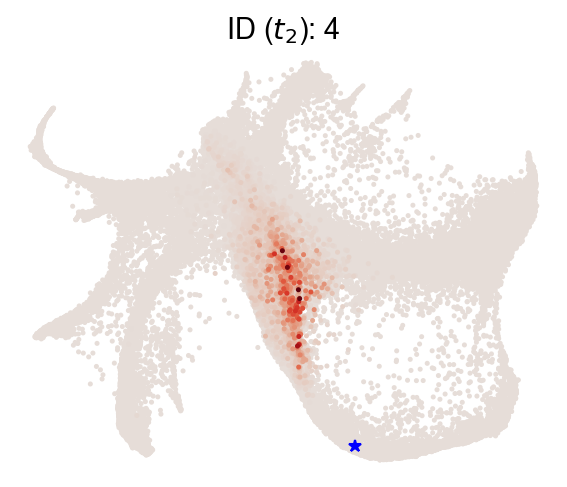

In [14]:
selected_state_id_list=[4]
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list, color_bar=False,
                                    used_Tmap='transition_map',map_backward=True)

#### Fate map

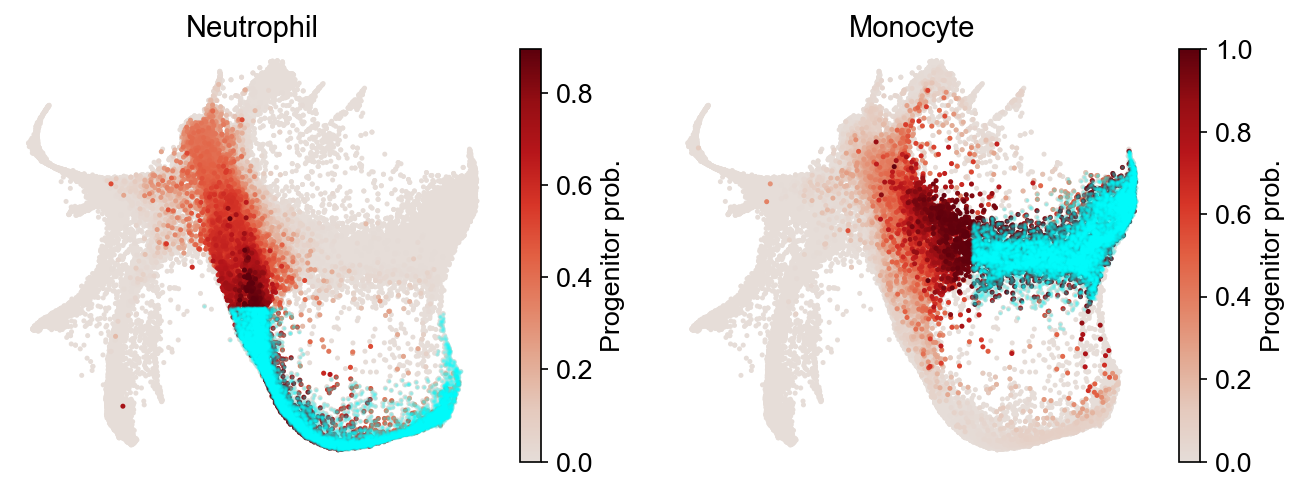

In [15]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',
               map_backward=True,plot_target_state=True,horizontal=True)

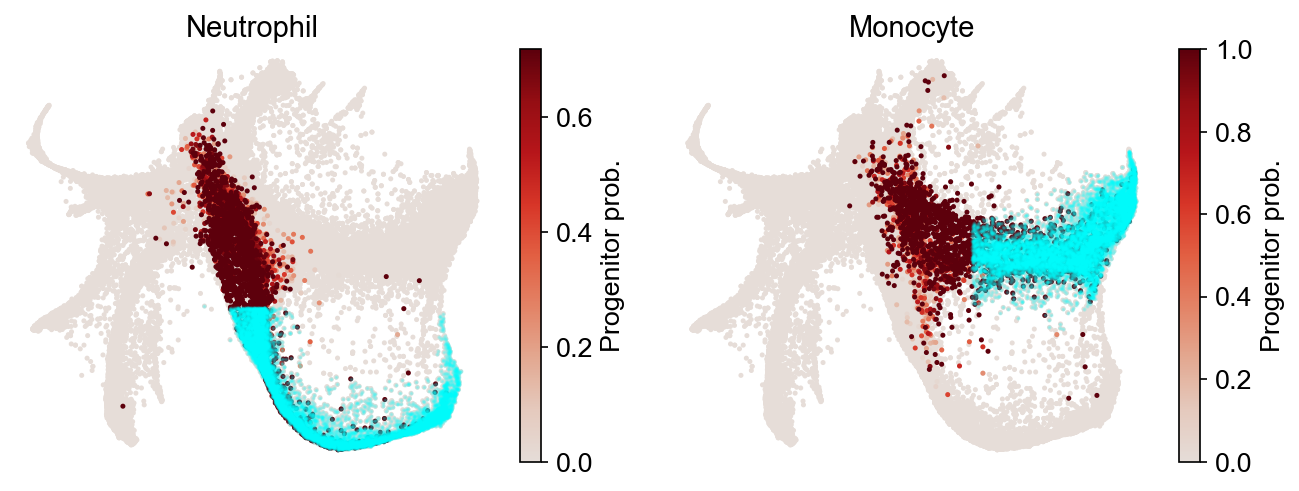

In [16]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],used_Tmap='intraclone_transition_map',
               map_backward=True,plot_target_state=True,horizontal=True)

#### Fate bias

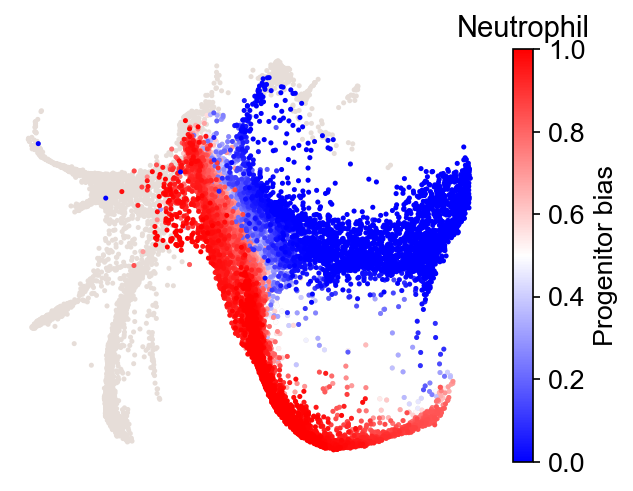

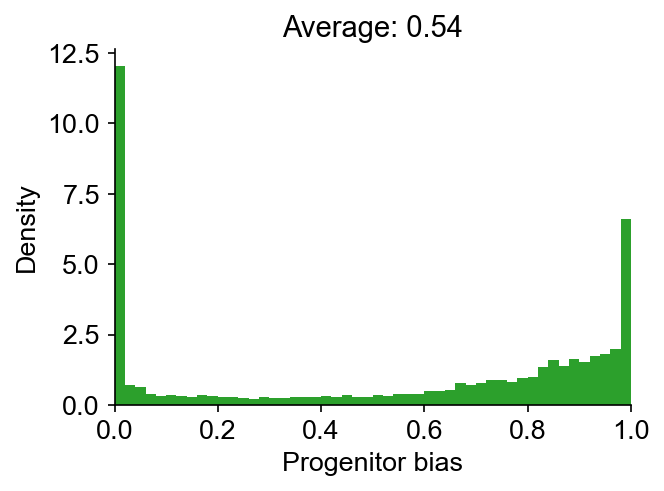

In [17]:
cs.pl.fate_bias(adata,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',
            selected_times=['4'],plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.1)

#### Fate coupling from the transition map

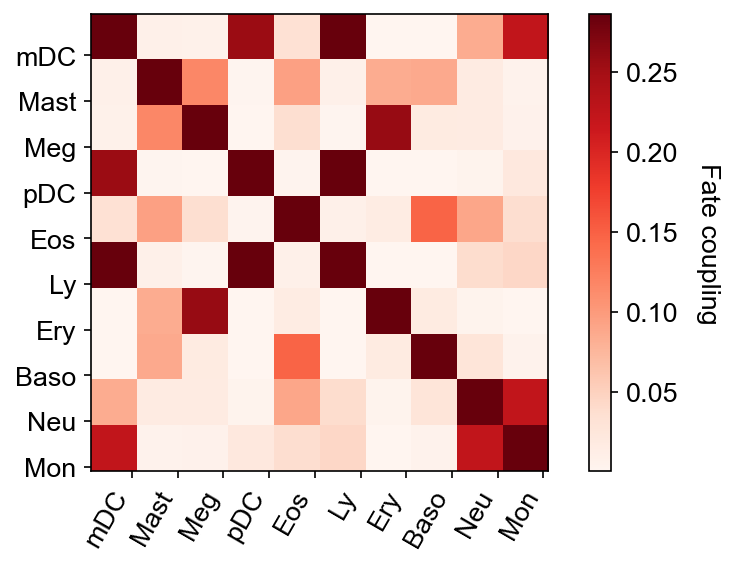

In [18]:
fate_array=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
coupling=cs.pl.fate_coupling_from_Tmap(adata,selected_fates=fate_array,used_Tmap='transition_map',rename_fates=celltype_names)


#### Hierarchy

In [19]:
cs.pl.fate_hierarchy_from_Tmap(adata,selected_fates=selected_fates,used_Tmap='transition_map',
                        rename_fates=celltype_names,plot_history=False)


            /-Ery
         /-|
      /-|   \-Meg
     |  |
   /-|   \-Mast
  |  |
  |  |   /-Baso
  |   \-|
--|      \-Eos
  |
  |      /-Mon
  |   /-|
  |  |   \-Neu
   \-|
     |      /-Ly
     |   /-|
      \-|   \-mDC
        |
         \-pDC


#### Dynamic trajectory inference

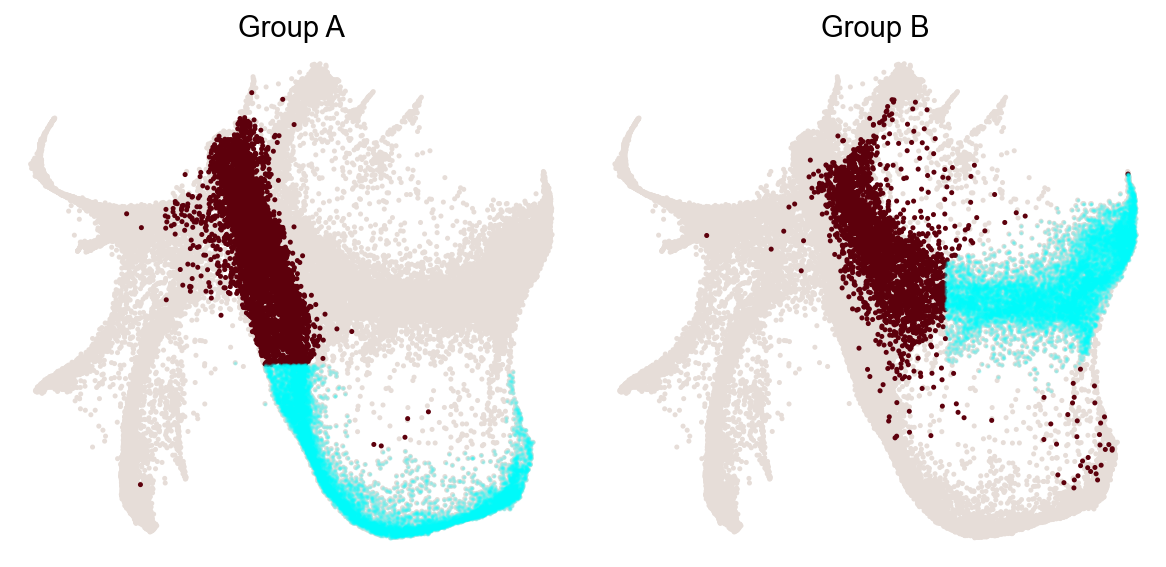

In [20]:
cs.pl.progenitor(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_Tmap='transition_map', map_backward=True, bias_threshold_A=0.5, bias_threshold_B=0.5, 
                    sum_fate_prob_thresh=0.2, avoid_target_states=True)


#### Gene trend along the dynamic trajectory

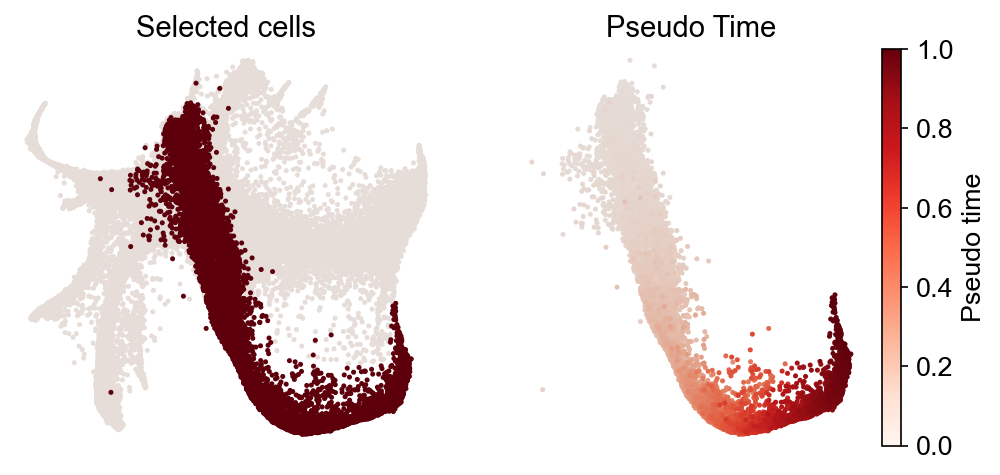

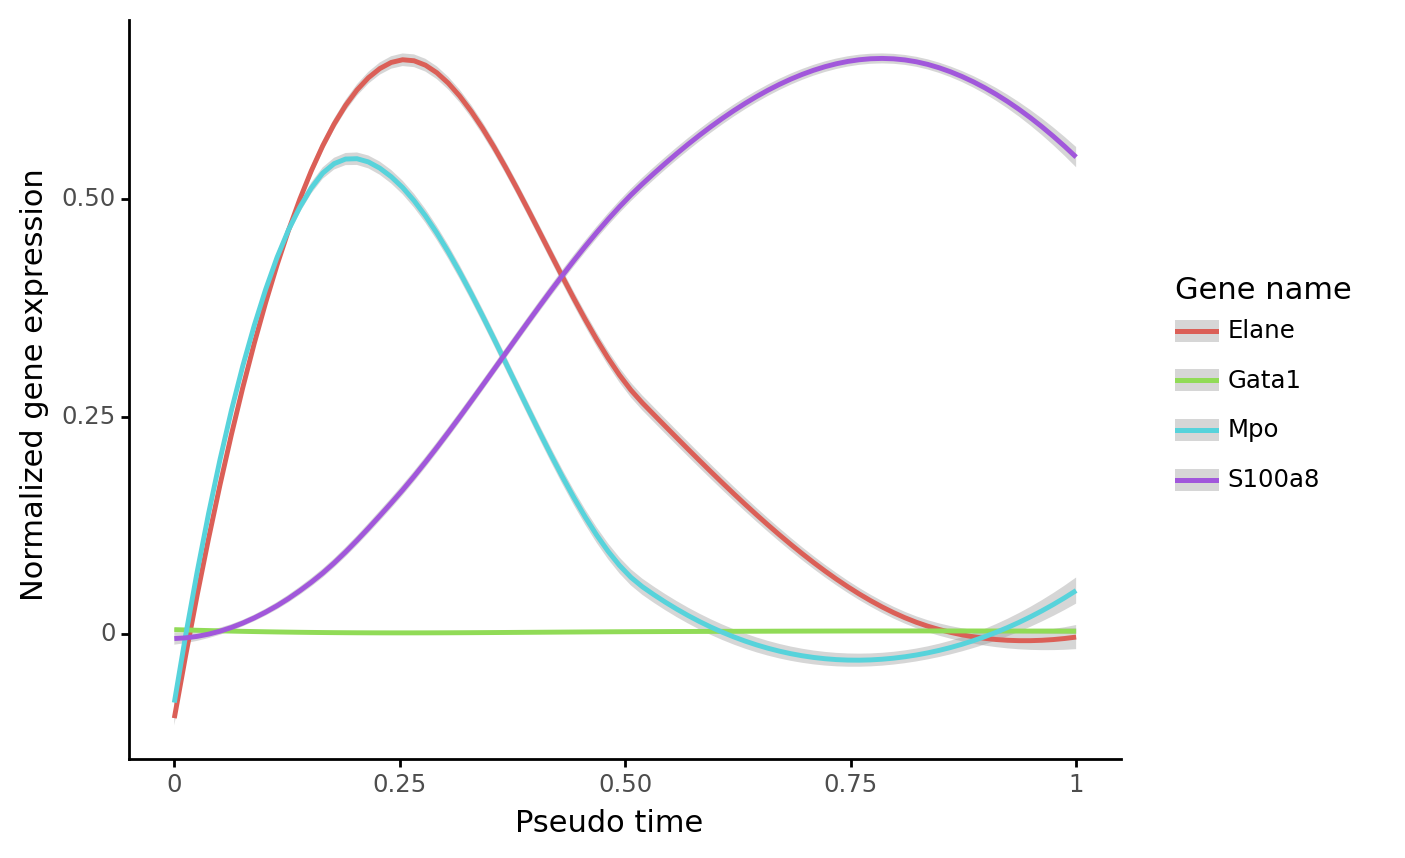

In [21]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      invert_PseudoTime=False)

## Part II: Infer transition map from end-point clones

When run for the firs time, assuming that the similarity matrices are pre-computed, it takes 73 mins. Around 40 mins of which are used to compute the initialized map.

We group time points '2' and '4' so that the inference on day 2 states (which has much fewer cells) are better. 

In [22]:
time_info=np.array(adata_orig.obs['time_info'])
time_info[time_info=='2']='24'
time_info[time_info=='4']='24'
adata_orig.obs['time_info']=time_info
adata_orig=cs.pp.initialize_adata_object(adata_orig)

Clones without any cells are removed.
Time points with clonal info: ['24' '6']


In [23]:
adata_1=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points=['24'],later_time_point='6',
    initialize_method='OT',OT_cost='GED',smooth_array=[20,15,10],max_iter_N=[1,3],
                    sparsity_threshold=0.2,use_full_Smatrix=True)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 24--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.974
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.142
Finishing Joint Optimization, used time 1022.3182091712952
-----------Total used time: 1053.0974760055542 s ------------


### Fate bias

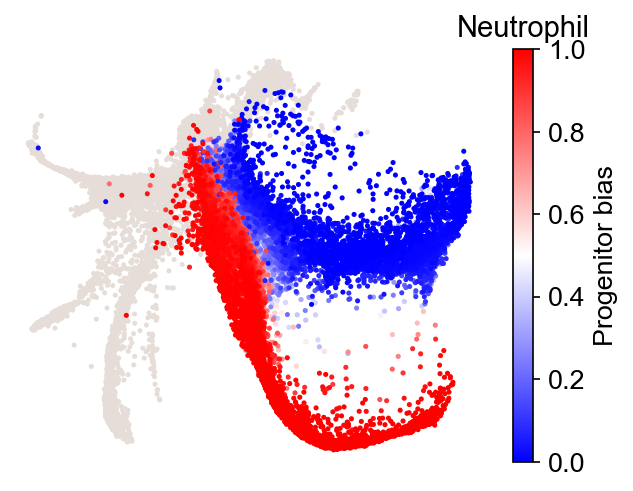

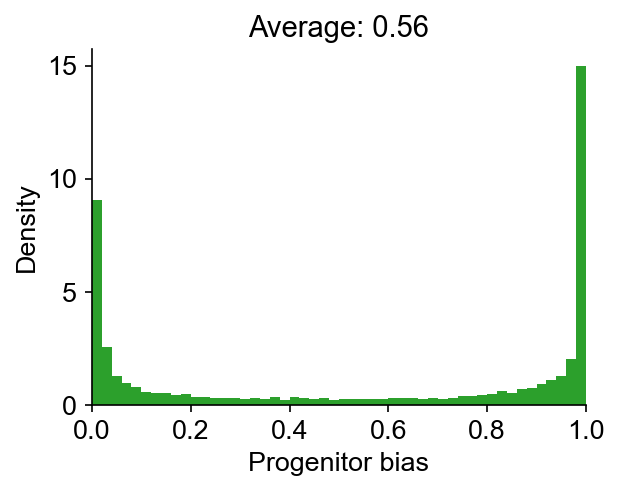

In [24]:
cs.pl.fate_bias(adata_1,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',
            plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.1)

### Fate coupling of the transition map

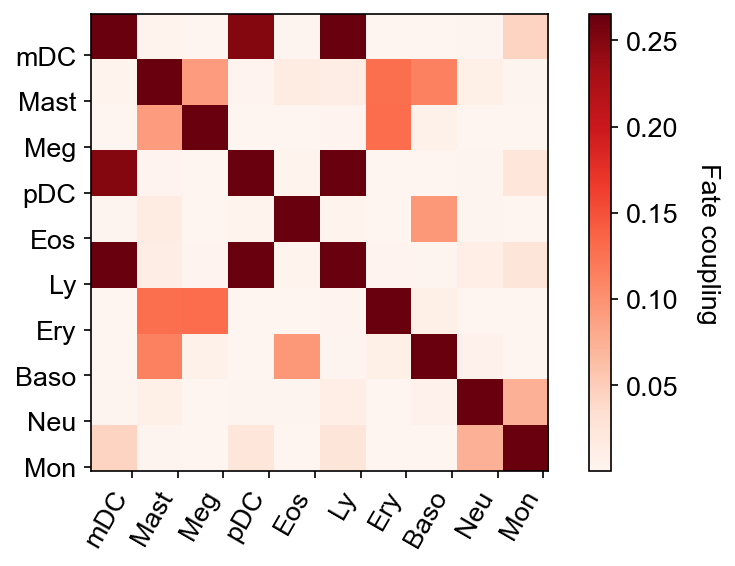

In [25]:
fate_array=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
coupling=cs.pl.fate_coupling_from_Tmap(adata_1,selected_fates=fate_array,used_Tmap='transition_map',
                        rename_fates=celltype_names,color_bar=True)


## Part III: Infer transition map state from information alone

In [26]:
adata_2=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points=['24'],later_time_point='6',
    initialize_method='OT',OT_cost='GED',smooth_array=[20,15,10],max_iter_N=[1,3],
                    sparsity_threshold=0.2,use_full_Smatrix=True)

Step I: Generate pseudo clones where each cell has a unique barcode-----


Trying to set attribute `.uns` of view, copying.


Step II: Perform joint optimization-----


Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 24--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.978
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.133
Finishing Joint Optimization, used time 1205.600352048874
-----------Total used time: 1257.3416302204132 s ------------


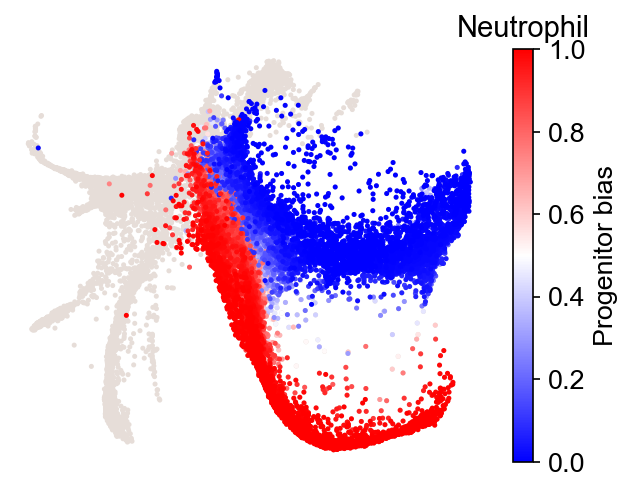

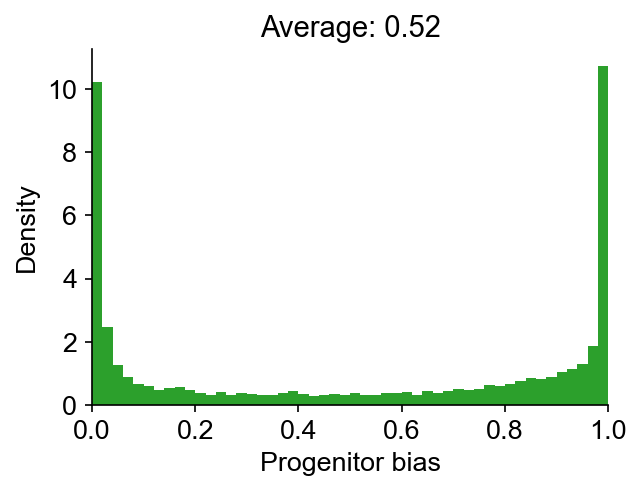

In [27]:
cs.pl.fate_bias(adata_2,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',
            plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.1)

## Part IV: Predict fate bias for Gata1+ states

### Load data

We load a dataset that also includes non-clonally labeled cells in the Gata1+ states (in total ~38K cells),  which increases the statistical power of DGE analysis.

In [28]:
cs.settings.data_path='LARRY_data_Gata1' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='LARRY_figure_Gata1' # A relative path to save figures. If not existed before, create a new one.
#adata_orig_1=cs.hf.read(f'{cs.settings.data_path}/LARRY_Gata1_lineage_adata_preprocessed.h5ad')
adata_orig_1=cs.datasets.hematopoiesis_Gata1_states()

In [29]:
adata_orig_1=cs.pp.initialize_adata_object(adata_orig_1)

Time points with clonal info: ['2' '4' '6']


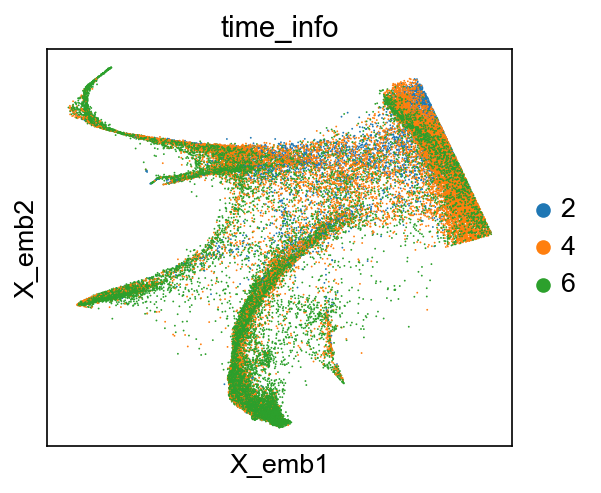

<Figure size 300x262.5 with 0 Axes>

In [30]:
cs.pl.embedding(adata_orig_1,color='time_info')

In [31]:
adata_orig_1

AnnData object with n_obs × n_vars = 38457 × 25289
    obs: 'n_counts', 'Source', 'Well', 'mito_frac', 'time_info', 'state_info'
    var: 'highly_variable'
    uns: 'AllCellCyc_genes', 'clonal_time_points', 'data_des', 'max_mito', 'min_tot', 'new_highvar_genes', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'

### Infer transition map from all clones

In [32]:
adata_3=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig_1,later_time_point='6',smooth_array=[20,15,10],
        sparsity_threshold=0.1,intraclone_threshold=0.1,extend_Tmap_space=True)

------Compute the full Similarity matrix if necessary------


Trying to set attribute `.uns` of view, copying.


------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 355
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.969
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 1270
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.985
-----------Total used time: 347.3354251384735 s ------------


### Fate bias

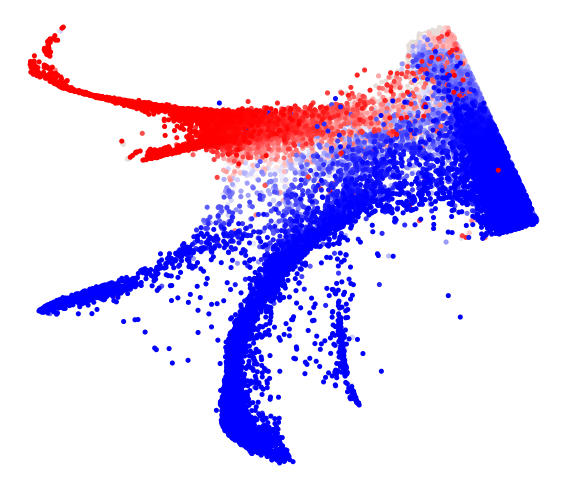

In [33]:
cs.pl.fate_bias(adata_3,selected_fates=[['Meg','Erythroid'],['Baso','Mast','Eos']],used_Tmap='transition_map',
            plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.05,
                       color_bar=False,method='norm-sum',show_histogram=False)

### Identify ancestor populations

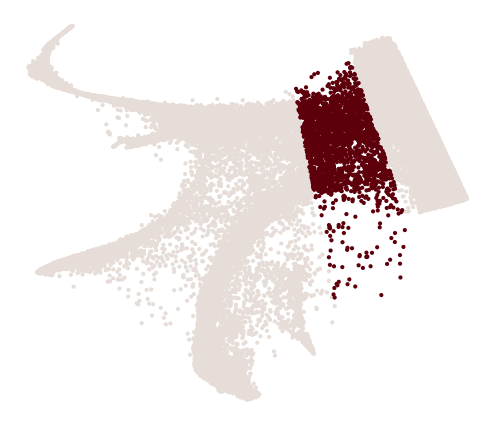

In [34]:
x_emb=adata_orig_1.obsm['X_emb'][:,0]
y_emb=adata_orig_1.obsm['X_emb'][:,1]

index_2=cs.hf.above_the_line(adata_orig_1.obsm['X_emb'],[0,-500],[-300,1000])
index_2_2=cs.hf.above_the_line(adata_orig_1.obsm['X_emb'],[-450,-600],[-600,800])

final_mask= (index_2_2) & (~index_2) #& index_3 & index_4 & index_5 #mask_1 &
cs.pl.customized_embedding(x_emb,y_emb,final_mask)

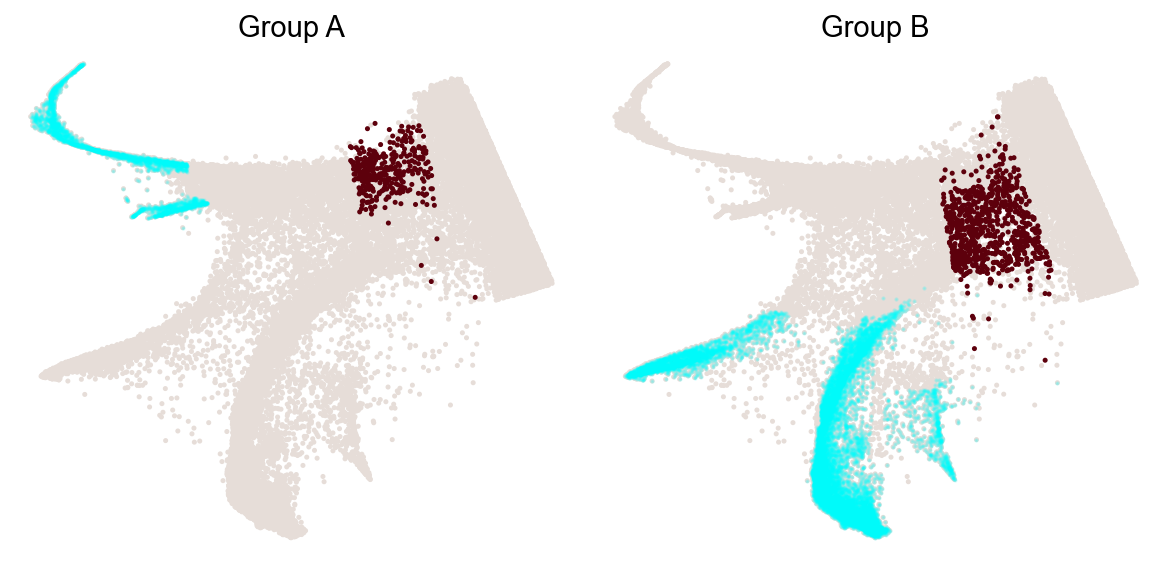

In [35]:
cs.pl.progenitor(adata_3, selected_fates=[['Meg','Erythroid'],['Baso','Mast','Eos']], 
 used_Tmap='transition_map', map_backward=True, bias_threshold_A=0.6,bias_threshold_B=0.3, mask=final_mask,
                method='norm-sum',sum_fate_prob_thresh=0, avoid_target_states=True)

### DGE analysis

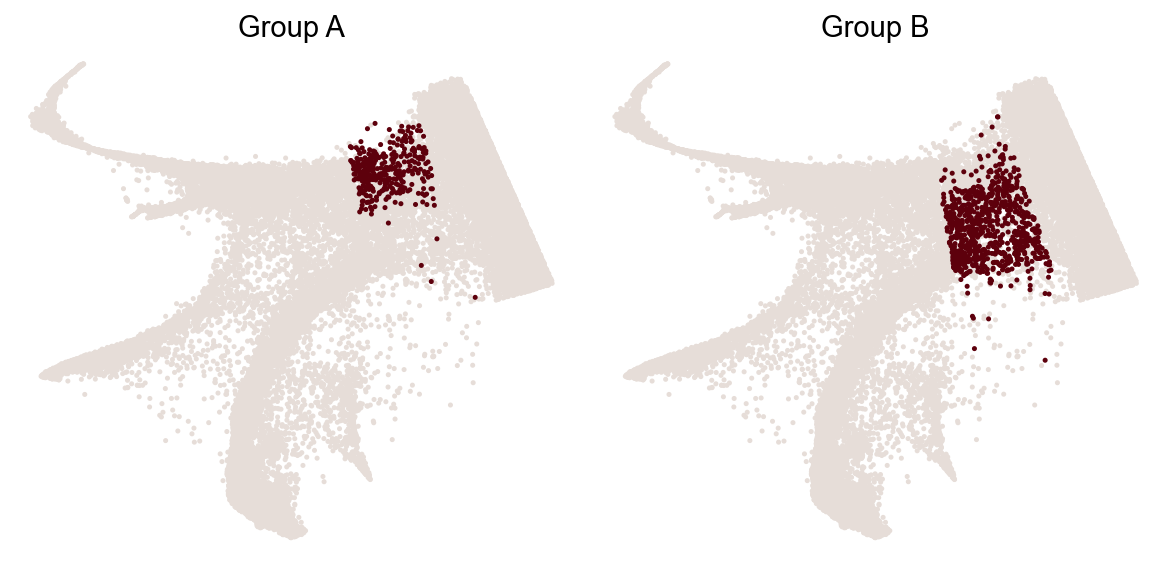

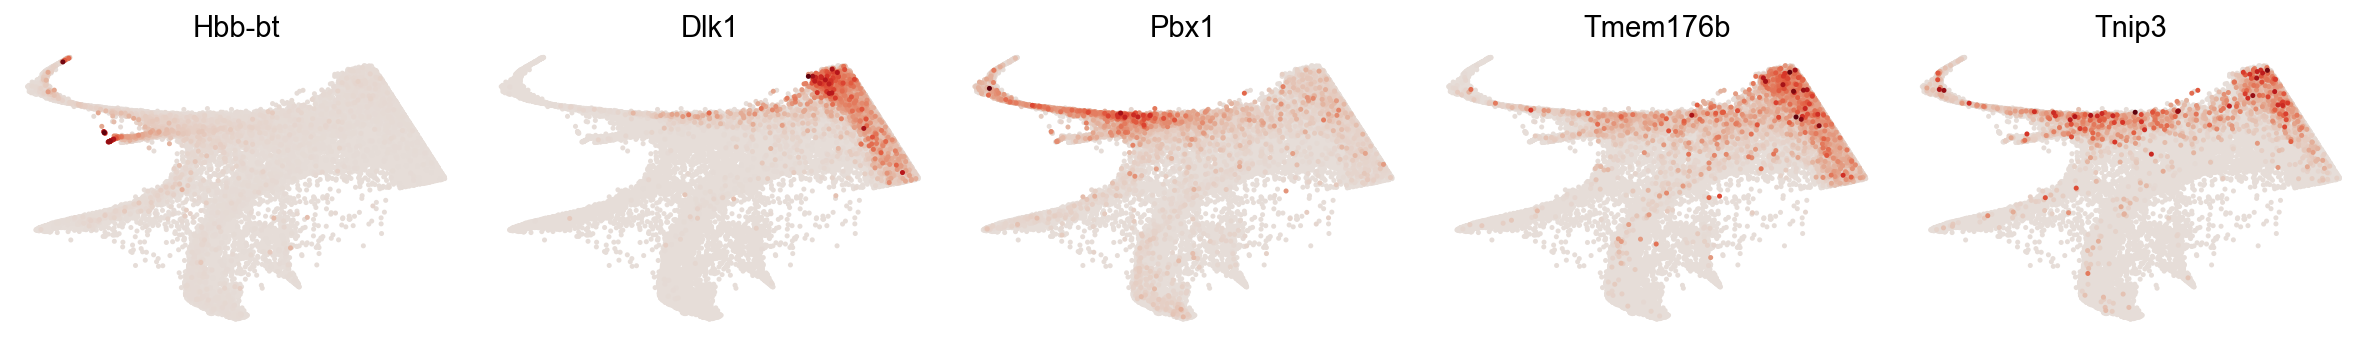

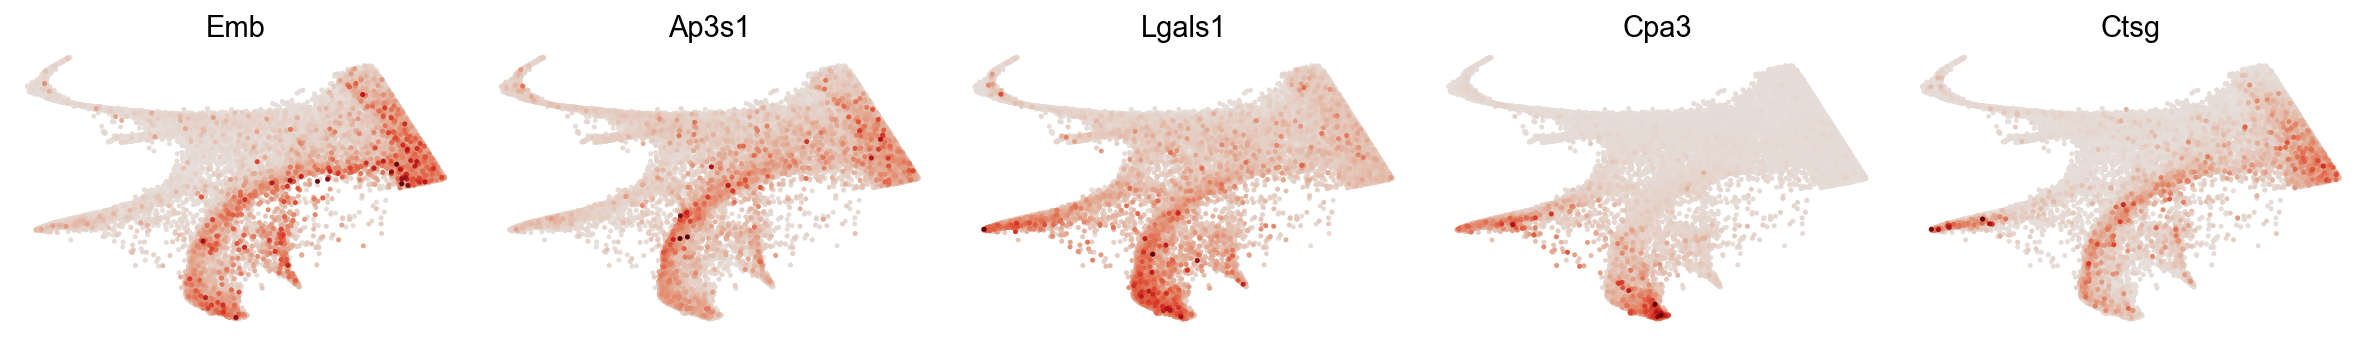

In [36]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata_3,plot_gene_N=5)

In [37]:
# All, ranked, DGE genes for group A
dge_gene_A

index      gene        Qvalue     mean_1     mean_2     ratio
0      28    Hbb-bt  2.325122e-12   1.084350   3.099235 -0.975757
1     192      Dlk1  1.888777e-03   0.362548   1.515336 -0.884444
2      18      Pbx1  3.260944e-16   0.123105   0.989597 -0.824983
3      21  Tmem176b  2.804040e-15   0.398115   1.341797 -0.744133
4      24     Tnip3  6.897902e-13   0.030880   0.721115 -0.739467
..    ...       ...           ...        ...        ...       ...
75    256     Rps19  1.020369e-02   6.227517   7.355206 -0.209175
76    114   mt-Atp6  8.440079e-05  41.971764  47.858364 -0.185217
77    152     Rpl23  5.600670e-04  16.664854  19.059944 -0.183436
78    230      Rpl7  5.590050e-03   8.353278   9.543811 -0.172852
79    359     Rpl19  4.459240e-02   4.011672   4.628918 -0.167566

[80 rows x 6 columns]

In [38]:
sub_predicted_upper=['Slc14a1','Plxnc1','Mef2c','Tnip3','Pbx1','Hbb-bt','Tmem176b','Car2','Pim2',  'Tsc22d1', 'Plcg2', 'Gmpr', 'Cd44', 'Irgm1', 
'Hsd17b10','Dlk1']
sub_predicted_lower=['Ctsg', 'Emb', 'Ccl9', 'Igfbp7', 'Ap3s1', 'Gstm1',  'Ms4a3', 'Fcgr3', 'Mpo', 
            'Cebpb','Thy1', 'Anxa3', 'Sell',  'Pcsk9','Fcgr2b','Cebpa','Cxcr4']

In [39]:
state_info=np.array(adata_3.obs['state_info'])
cell_group_A=adata_3.obs['cell_group_A']
state_info[cell_group_A]='MegEr_Prog'
cell_group_B=adata_3.obs['cell_group_B']
state_info[cell_group_B]='EMB_Prog'

In [40]:
adata_3.obs['state_info']=state_info

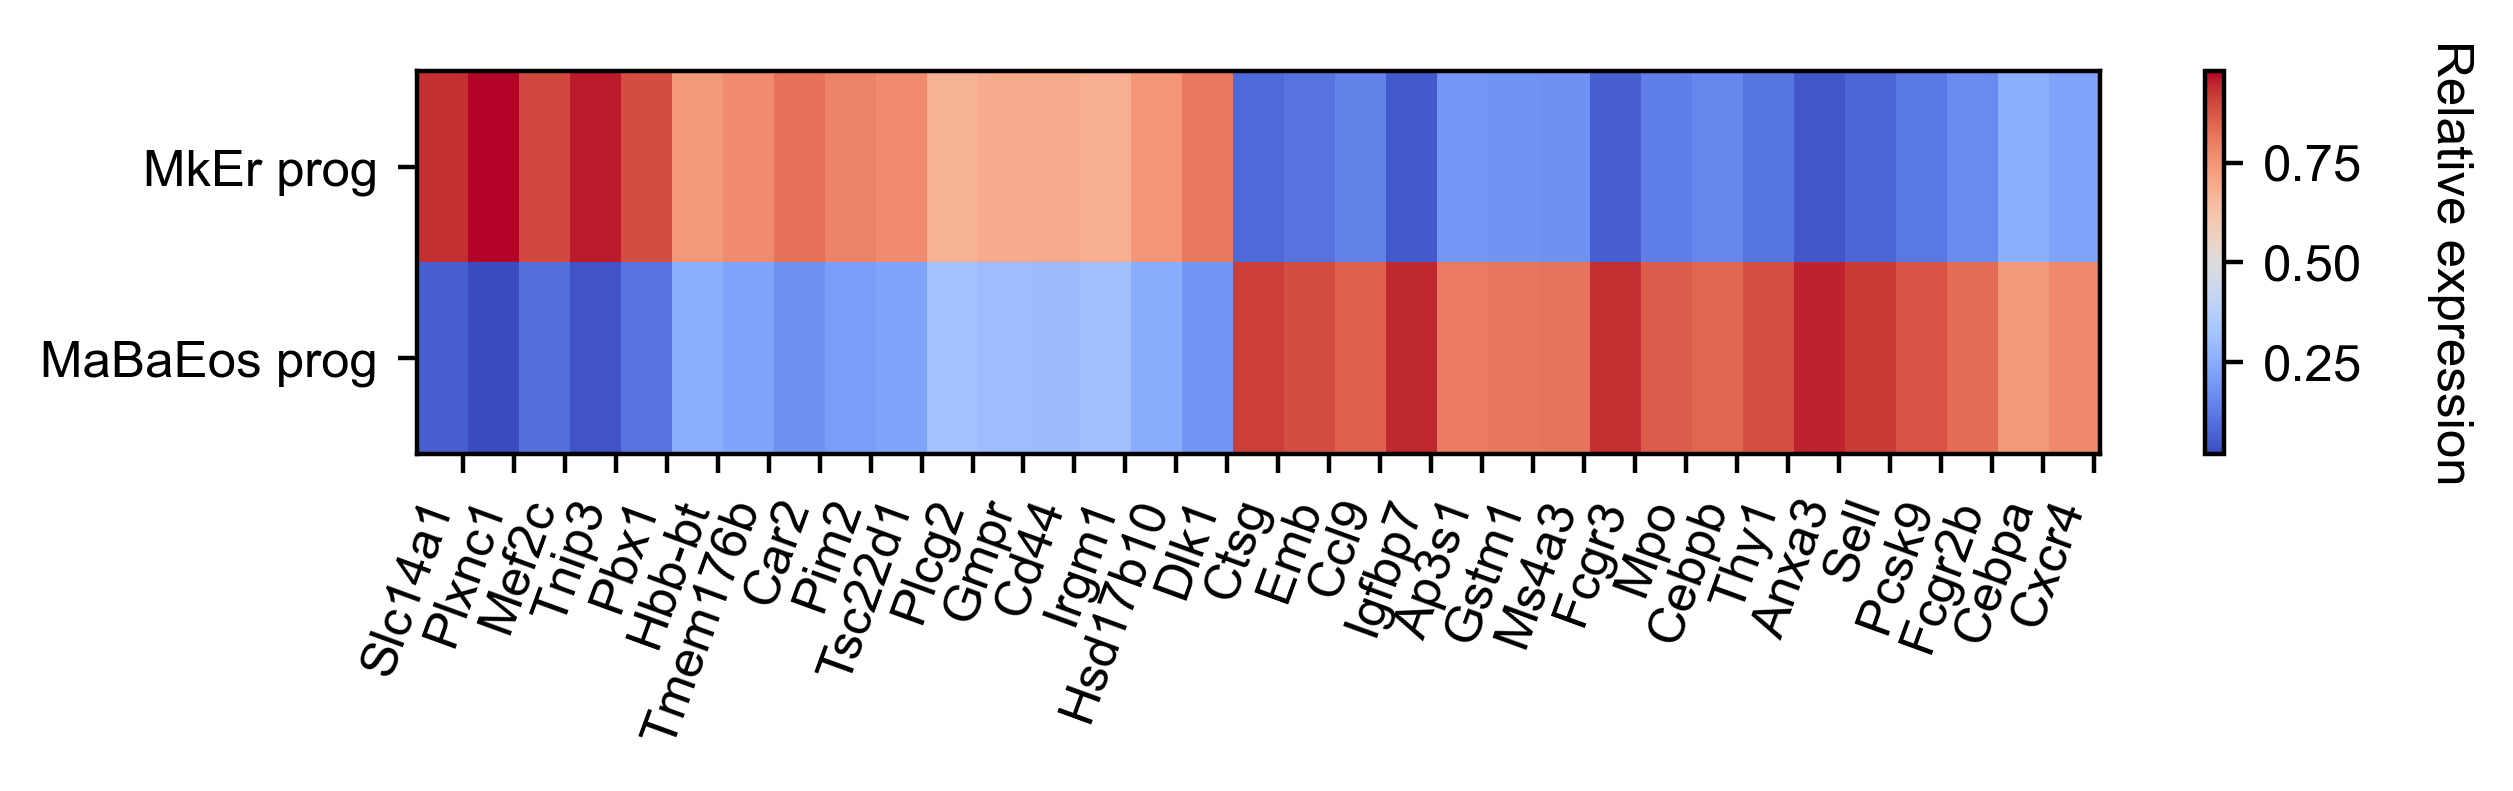

In [41]:
cs.settings.set_figure_params(format='pdf',figsize=[4,3.5],dpi=200,fontsize=10,pointsize=3) 

gene_list=sub_predicted_upper+sub_predicted_lower
selected_fates=['MegEr_Prog','EMB_Prog']
renames=['MkEr prog','MaBaEos prog']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata_3,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)